# HoG classifier
The current exercise builds on the HOG exercises from the previous exercise
, but it can also be successfully completed independently.
The cell below imports the necessary libraries, loads an example image and extracts and plots the HOG features along the original image. 


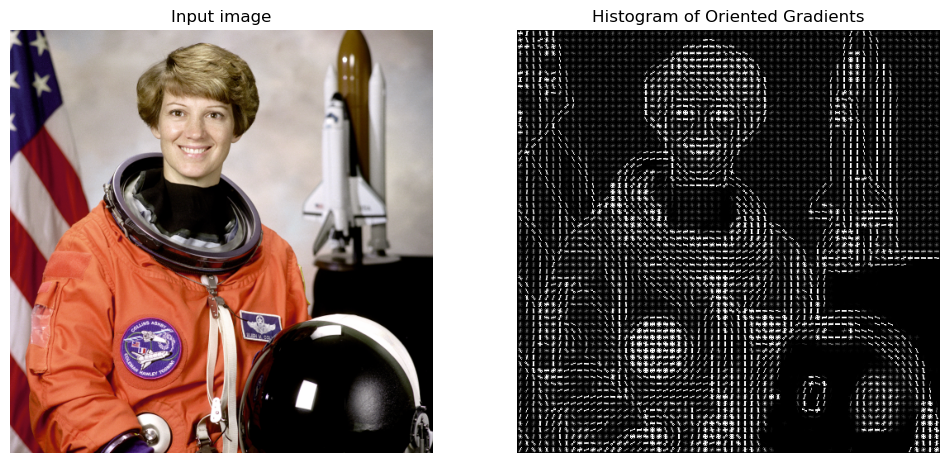

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import chain

from skimage import data, transform, feature, exposure
from skimage.feature import hog
from sklearn.datasets import fetch_lfw_people
from skimage.color import rgb2gray
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.svm import LinearSVC
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Creating the training data
Through the following steps you will construct the training data, which comprises of HOG features extracted from images containing faces and non-faces. The constructed set will be used for training a binary classification model.
**Face Images (Positive class)**
You will use the "Labeled Faces in the Wild" dataset ("LFW") for the images containing faces as provided by scikit-learn. The cell below loads the dataset, extracts the facial images, and displays a selection of these images for visualization. 

**Info**
When first loading the dataset, please be aware that the code may require a few minutes to finish execution.



(13233, 62, 47)


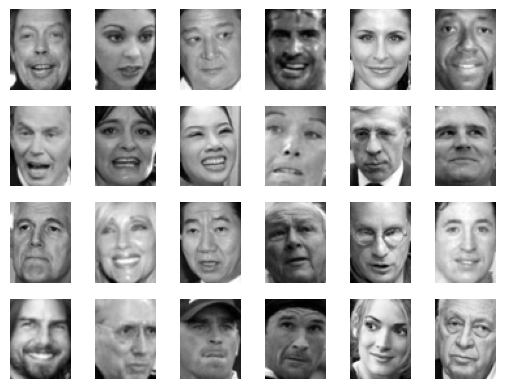

In [2]:
faces = fetch_lfw_people()

face_images = faces.images
print(face_images.shape) # 13233 face images to use for training

# Visualize Positive Set (face images)

fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(face_images[500 * i], cmap='gray')
    axi.axis('off')

**Non-face Images (Negative class)**
For non-face images other images from the Scikit-Image library are used. The cell below loads these images. The `PatchExtractor`
 method is used for data augmentation.


In [3]:
# negative data samples
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
# images = []

images = [data.camera(), data.coins(),data.text(),data.moon(),data.page(),data.clock(),data.coffee(),data.hubble_deep_field()]
img = []
for im in images:
    if len(im.shape)==3:
        img.append(rgb2gray(im))
    else:
        img.append(im)

### Make patches of the different negative samples to generate a larger dataset

def extract_patches(img, N, scale=1.0, patch_size=face_images[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

non_face_images = np.vstack([extract_patches(im, 1000, scale)
                              for im in img for scale in [0.5,1.0,2.0]]) # [0.5, 1.0, 2.0]
print(non_face_images.shape)

(24000, 62, 47)


The cell below visualizes the newly created non-face image patches:


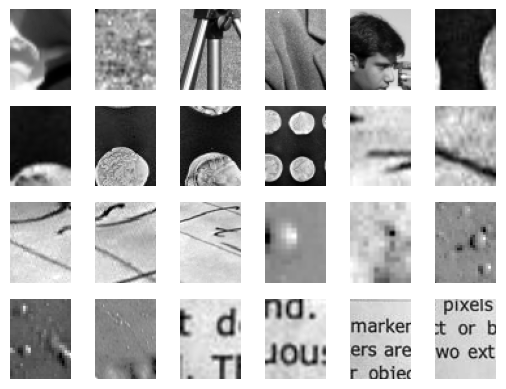

In [4]:
# Visualize Negative Set

fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(non_face_images[600 * i], cmap='gray')
    axi.axis('off')

The cell below combines the face and the non face images, then extracts the HOG features from the combined set. It also creates the target labels for the newly assembled training dataset. 


In [5]:
X_train = np.array([hog(im, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
                    for im in chain(face_images, non_face_images)])


Y_train = np.zeros(X_train.shape[0])
Y_train[:face_images.shape[0]] = 1

## Training a classifier
In the following task you will train a linear classifier using HoG features.

---
**Task 1 (easy): Implement a classifier👩‍💻**
The cell below contains the classification model. Your task is to:
1. Fit the model to the training data.

2. Calculate and print the accuracy of the classifier on the training data.

3. Construct and plot a confusion matrix of the model predictions on the training set.

4. Based on the accuracy and the confusion matrix, discuss how effective the model is. 



---

4. Looking only at the accuracy and the confusion matrix we see that the model predicts whether the image contains a face well. It has a high axxuracy $~0.99$ and seems to not be too imbalanced in the confusion matrix

Accuracy: 0.9961861789272957
[[23970    30]
 [  112 13121]]


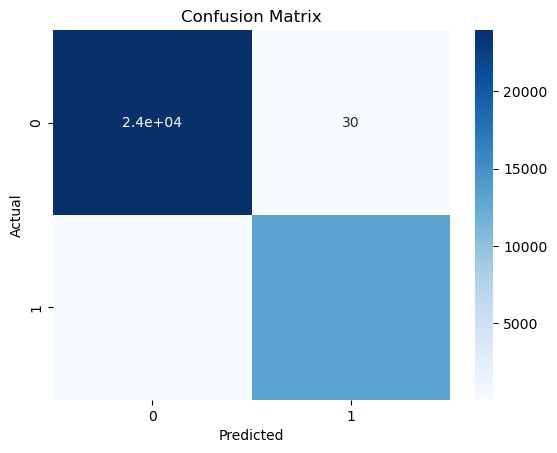

In [9]:
from sklearn.metrics import accuracy_score

model = LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0)

# 1
model_fitted = model.fit(X_train, Y_train)
Y_pred = model_fitted.predict(X_train)

# 2
model_accuracy = accuracy_score(Y_train, Y_pred)
print(f'Accuracy: {model_accuracy}')

# 3
model_confusion_matrix = confusion_matrix(Y_train, Y_pred)
print(model_confusion_matrix)
sns.heatmap(model_confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Testing on new images
In this section you will evaluate the trained model on a novel image. You will implement a function that slides over the image and breaks it down to smaller patches. Then you will extract the HOG features from these patches, and categorize them as either a face (1) or a non-face (0) image. 


(120, 100)


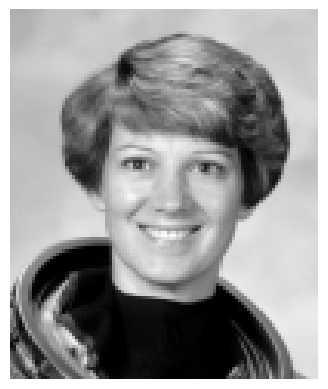

In [10]:
# Load a test image
test_img = data.astronaut()
test_img = rgb2gray(test_img)
test_img = transform.rescale(test_img, 0.5)
test_img = test_img[:120, 60:160]


plt.imshow(test_img, cmap='gray')
plt.axis('off')
print(test_img.shape)


---
**Task 2 (hard): Sliding window👩‍💻**
1. Implement the method `sliding_windows`
 that takes the test image and extracts image patches from it. 
    - The function should iteratively slide over the entire image and extract image patches of the same size as the inputs the classifier was trained on.
    - The function should return a tuple of the coordinates of the upper left corner of each subimage patch, and the patch itself.




---

In [22]:
# Sliding Window function - Goes Over the image patch by patch
# and computes the HOG features for each patch.

# This configuration results in overlapping boxes
# def sliding_window(img, patch_size=face_images[0].shape, istep=8, jstep=5):
def sliding_window(img, patch_size=face_images[0].shape, istep=16, jstep=10):
    indicies = []
    patches = []

    for i in range(0, patch_size[0], istep):
        for j in range(0, patch_size[1], jstep):
            indicies.append((i,j))
            patches.append(img[i:i+patch_size[0], j:j+patch_size[1]])
            
    return indicies, patches

# Write you code iterating over the test image here.
# EASIEST approach is to use a foor loop for each image dimension


---
**Task 3 (medium): Classifying the test image👩‍💻**
In the following task you have to:
1. Extract the HOG features for all patches from the test image (`test_img`
) by making use of the `sliding_window`
 and `hog`
 functions. Store the features in an array called `hog_patches`
 and the corresponding indices in an array called `indices`
.

2. Use the model to classify the extracted HOG patches and store the results in an array called `labels`
.

3. Use the existing code to visualize the detections. 



---

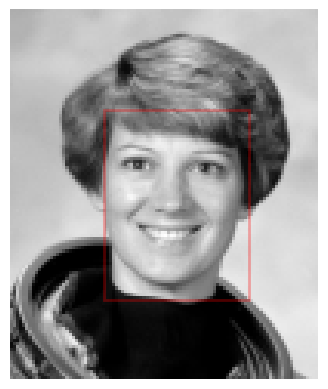

In [23]:
# Apply sliding window function to test_img

# 1
indices, patches = sliding_window(test_img)
hog_patches = np.array([hog(patch, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False) for patch in patches])

# 2
labels = model_fitted.predict(hog_patches)

# 3
# Visualize the detections
fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

Ni, Nj = face_images[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))

## Reflections

---
**Task 4 (easy): Reflections💡**
- Summarize the overall process of face detection implemented in this exercise. 
- There are multiple overlapping boxes of the same detected face in the test image. How could you ensure that a face is only detected once? 
- How could the face detection pipeline be improved? Consider the following steps: training data construction, model fitting, test images.


---

Summary of the overall process:
1. Prepare the data set: 
    - Normalize: e.g. gray-scale,
    - Create a test and train split of the hog features
2. Train the model
3. Evaluate the model
4. Apply the model

Multiple overlapping boxes:
Techniques like Non-Maximum Suppression can be used to mitigate this. Not a solution but if you choose the correct patch size, then there are no overlapping boxes

Improvements to:
- Training data construction: We have a slightly imbalanced dataset (more faces than non-faces), hence it could be improved by e.g. sampling in more faces. Further, we could also rotate and twist some images to cover more cases
- Model fitting: We could try out different parameters for the hog features, we could perform cross-validation
- test images: We could try to rotate the images to get a wider variety of images, have a wider variety of images